In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import sys
import warnings

import joblib

sys.path.append("/app")
from copy import deepcopy
from pathlib import Path

import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib.dates import DateFormatter
from tqdm.notebook import tqdm

from conceptual_runs.scripts.data_readers import metric_df, read_gauge
from visualizations.scripts.drawer import russia_plots, russia_plots_n

gpd.options.io_engine = "pyogrio"

warnings.simplefilter(action="ignore", category=FutureWarning)

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]


### Read necessary geometry

In [5]:
gauges_file = gpd.read_file("../data/geometry/russia_gauges.gpkg")
gauges_file["gauge_id"] = gauges_file["gauge_id"].astype(str)
gauges_file = gauges_file.set_index("gauge_id")
ws_file = gpd.read_file("../data/geometry/russia_ws.gpkg")
ws_file = ws_file.set_index("gauge_id")
ws_file = ws_file[ws_file["new_area"] <= 50000]


def lim_definer(area: float):
    lim_1, lim_2, lim_3, lim_4 = 100, 2000, 10000, 50000

    if area < lim_1:
        return "а) < 100 $км^2$"
    elif (area >= lim_1) & (area <= lim_2):
        return "б) 100 $км^2$ - 2 000 $км^2$"
    elif (area > lim_2) & (area <= lim_3):
        return "в) 2 000 $км^2$ - 10 000 $км^2$"
    elif (area > lim_3) & (area <= lim_4):
        return "г) 10 000 $км^2$ - 50 000 $км^2$"
    else:
        return "> 50 000 $км^2$"


ws_file["size"] = ws_file.loc[:, "new_area"].apply(lambda x: lim_definer(x))
ws_file["size"] = pd.Categorical(
    ws_file["size"],
    [
        "а) < 100 $км^2$",
        "б) 100 $км^2$ - 2 000 $км^2$",
        "в) 2 000 $км^2$ - 10 000 $км^2$",
        "г) 10 000 $км^2$ - 50 000 $км^2$",
    ],
)

basemap_data = gpd.read_file("../data/geometry/basemap_2023.gpkg")

basin_districts = gpd.read_file("../data/geometry/basin_districts_2024.gpkg")
basin_districts = basin_districts.reset_index(drop=True)
# basin_districts = basin_districts.drop([26, 27])
# fixed umgs shapes
basin_districts = basin_districts.reindex(
    [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        26,
        10,
        11,
        12,
        27,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        9,
        13,
    ]
)
basin_districts = basin_districts.reset_index(drop=True)
basin_districts = basin_districts.rename(columns={"BAS_OKRUG": "name1"})


In [6]:
def read_table_gauge_str(
    table_path: str, index_filter: pd.Index = pd.Index([])
) -> tuple[pd.DataFrame, float]:
    table = pd.read_csv(table_path)
    if "Unnamed: 0" in table.columns:
        table = table.rename(columns={"Unnamed: 0": "gauge_id"})
    table["gauge_id"] = table["gauge_id"].astype(str)
    table = table.set_index("gauge_id")

    if index_filter.empty:
        pass
    else:
        table = table.loc[table.index.isin(index_filter)]
    median_nse = table["NSE"].median()
    return table, median_nse

### Use only gauges from LSTM model

In [10]:
hbv_table = pd.read_csv(
    "/app/conclusions/tables/HBV_res_mle_NSE.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)

gr4j_table = pd.read_csv(
    "/app/conclusions/tables/GR4J_res_mle_NSE.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
rfr_table = pd.read_csv(
    "/app/conclusions/tables/res_rfr_cv.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
lstm_regional = pd.read_csv(
    "/app/conclusions/tables/cudalstm_q_mm_day_mswep_era5_res.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
lstm_single = pd.read_csv(
    "/app/conclusions/tables/Single_LSTM_table.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
lstm_no_static = pd.read_csv(
    "/app/conclusions/tables/LSTM_no_static_res.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)

common_index = (
    hbv_table.index.intersection(gr4j_table.index)
    .intersection(rfr_table.index)
    .intersection(lstm_regional.index)
    .intersection(ws_file.index)
    .intersection(gauges_file.index)
    .intersection(lstm_single.index)
    .intersection(lstm_no_static.index)
)


ws_file = ws_file.loc[common_index, :]
gauges_file = gauges_file.loc[common_index, :]
gauges_file["size"] = np.nan
gauges_file = gauges_file.combine_first(ws_file)
gauges_file = gauges_file.set_crs(epsg=4326)

### HBV and GR4J

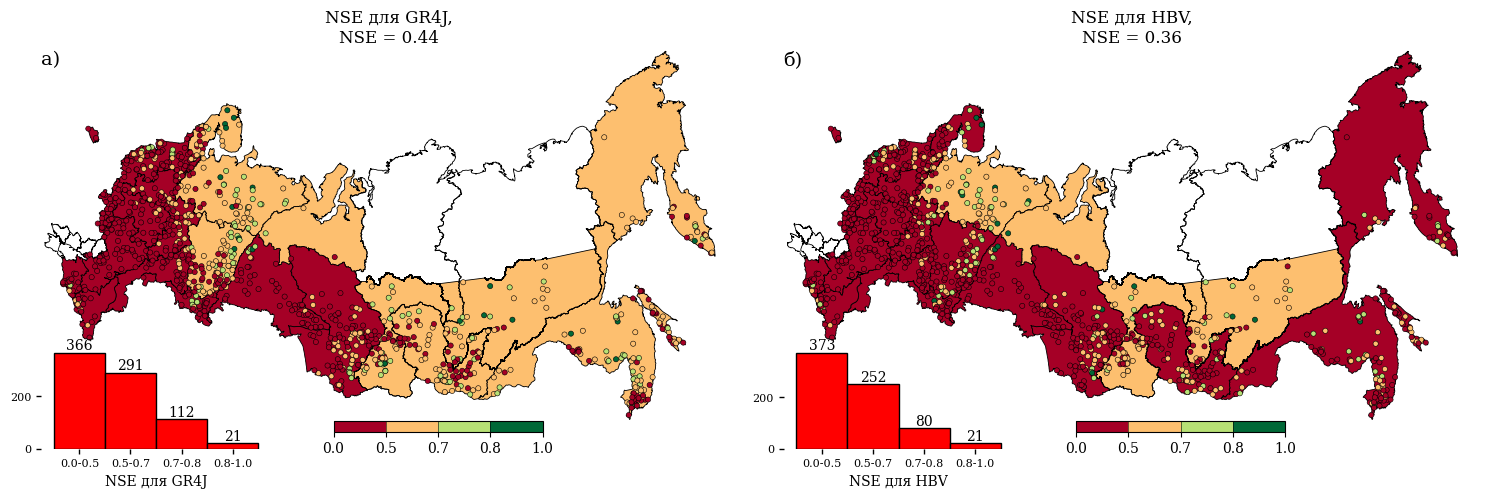

In [12]:
hbv_table, nse_hbv = read_table_gauge_str(
    table_path="/app/conclusions/tables/HBV_res_mle_NSE.csv", index_filter=common_index
)
gr4j_table, nse_gr4j = read_table_gauge_str(
    table_path="/app/conclusions/tables/GR4J_res_mle_NSE.csv", index_filter=common_index
)

hbv_gr4j_nse = gauges_file.loc[:, ["geometry"]]

hbv_gr4j_nse.loc[:, ["NSE GR4J", "NSE HBV"]] = pd.concat(
    [gr4j_table.loc[common_index, "NSE"], hbv_table.loc[common_index, "NSE"]],
    axis=1,
).values
hbv_gr4j_nse = hbv_gr4j_nse.dropna()


for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = hbv_gr4j_nse.loc[
        [geom.intersects(gage_point) for gage_point in hbv_gr4j_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["NSE GR4J", "NSE HBV"]] = ugms_part[["NSE GR4J", "NSE HBV"]].median()

basin_districts.loc[[26, 27], ["NSE GR4J", "NSE HBV"]] = np.nan

meteo_nse = russia_plots_n(
    gdf_to_plot=hbv_gr4j_nse,
    basemap_data=basemap_data,
    figsize=(15, 10),
    nrows=1,
    ncols=2,
    label_list=["а)", "б)"],
    columns_from_gdf=["NSE GR4J", "NSE HBV"],
    hist_name=["NSE для GR4J", "NSE для HBV"],
    with_histogram=True,
    title_text=[
        f"NSE для GR4J,\nNSE = {nse_gr4j:.2f}",
        f"NSE для HBV,\nNSE = {nse_hbv:.2f}",
    ],
    ugms=True,
    ugms_gdf=basin_districts,
)


In [13]:
gr4j_hbv = pd.concat([hbv_table.median().to_frame().T, gr4j_table.median().to_frame().T])

gr4j_hbv.index = pd.Index(["HBV", "GR4J"])

gr4j_hbv.to_excel("/app/conclusions/tables/gr4j_hbv_statistics.xlsx", float_format="%.2f")

### Random forest

#### Calculate files from Random Forest results

In [97]:
rfr_metric = list()
for gauge_id in tqdm(list(i.stem for i in Path("/app/data/conceptual_models/rfr_cv/").glob("*.joblib"))):
    _, test = read_gauge(gauge_id=gauge_id, simple=True)

    X_test = deepcopy(test)
    for days in (2**n for n in range(6)):
        X_test[[f"prcp_{days}"]] = test[["prcp_e5l"]].rolling(window=days).sum()
        X_test[[f"t_min_mean_{days}"]] = test[["t_min_e5l"]].rolling(window=days).mean()
        X_test[[f"t_max_mean_{days}"]] = test[["t_min_e5l"]].rolling(window=days).mean()
    X_test = X_test.dropna()

    feature_cols = [
        item
        for sublist in [
            [f"{var}_{day}" for day in (2**n for n in range(6))]
            for var in ["prcp", "t_min_mean", "t_max_mean"]  # "t_min_sum", "t_max_sum"]
        ]
        for item in sublist
    ]
    X_test = X_test[feature_cols]
    X_test = X_test.to_numpy()
    # create target
    Y_test = test[["q_mm_day"]]
    Y_test = Y_test.to_numpy().ravel()

    rfr_model = joblib.load(f"/app/data/conceptual_models/rfr_cv/{gauge_id}.joblib")
    # get prediction
    fin_df = test.iloc[31:, [0]]
    fin_df["q_mm_rfr"] = rfr_model.predict(X_test)

    rfr_metric.append(metric_df(gauge_id, predictions=fin_df["q_mm_rfr"], targets=fin_df["q_mm_day"]))

  0%|          | 0/1048 [00:00<?, ?it/s]

In [102]:
pd.concat(rfr_metric).to_csv("/app/conclusions/tables/res_rfr_cv.csv")


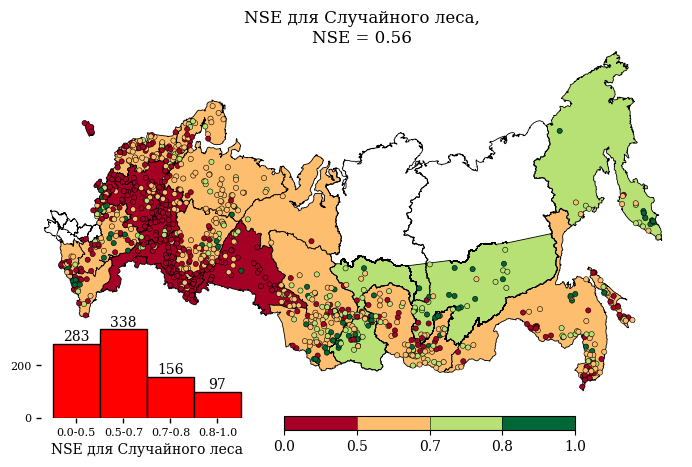

In [17]:
rfr_table, rfr_nse = read_table_gauge_str(
    table_path="/app/conclusions/tables/res_rfr_cv.csv", index_filter=common_index
)

rfr_geom_nse = gauges_file.loc[:, ["geometry"]]

rfr_geom_nse.loc[:, ["NSE Random Forest"]] = pd.concat(
    [rfr_table.loc[common_index, "NSE"]],
    axis=1,
).values
rfr_geom_nse = rfr_geom_nse.dropna()


for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = rfr_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in rfr_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["NSE Random Forest"]] = ugms_part[["NSE Random Forest"]].median()

basin_districts.loc[[26, 27], ["NSE Random Forest"]] = np.nan

meteo_nse = russia_plots_n(
    gdf_to_plot=rfr_geom_nse,
    basemap_data=basemap_data,
    figsize=(10, 5),
    nrows=1,
    ncols=1,
    label_list=[""],
    columns_from_gdf=["NSE Random Forest"],
    hist_name=["NSE для Случайного леса"],
    with_histogram=True,
    title_text=[f"NSE для Случайного леса,\nNSE = {rfr_nse:.2f}"],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


In [19]:
rfr = pd.concat([rfr_table.median().to_frame().T])

rfr.index = pd.Index(["Random Forest"])

rfr.to_excel("/app/conclusions/tables/random_forest_statistics.xlsx", float_format="%.2f")


### LSTM-vanila, LSTM-single, LSTM-regional

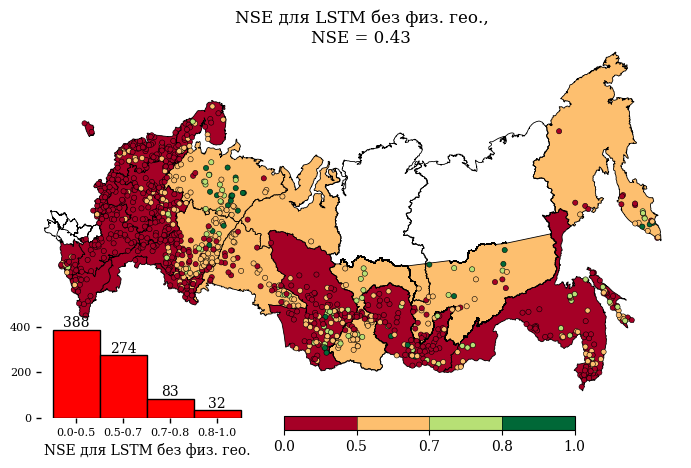

In [20]:
lstm_vanila_table, lstm_vanila_nse = read_table_gauge_str(
    table_path="/app/conclusions/tables/LSTM_no_static_res.csv", index_filter=common_index
)

lstm_vanila_geom_nse = gauges_file.loc[:, ["geometry"]]

lstm_vanila_geom_nse.loc[:, ["NSE LSTM без физ. гео."]] = pd.concat(
    [lstm_vanila_table.loc[common_index, "NSE"]],
    axis=1,
).values
lstm_vanila_geom_nse = lstm_vanila_geom_nse.dropna()


for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_vanila_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_vanila_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["NSE LSTM без физ. гео."]] = ugms_part[["NSE LSTM без физ. гео."]].median()

basin_districts.loc[[26, 27], ["NSE LSTM без физ. гео."]] = np.nan

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_vanila_geom_nse,
    basemap_data=basemap_data,
    figsize=(10, 5),
    nrows=1,
    ncols=1,
    label_list=[""],
    columns_from_gdf=["NSE LSTM без физ. гео."],
    hist_name=["NSE для LSTM без физ. гео."],
    with_histogram=True,
    title_text=[f"NSE для LSTM без физ. гео.,\nNSE = {lstm_vanila_nse:.2f}"],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


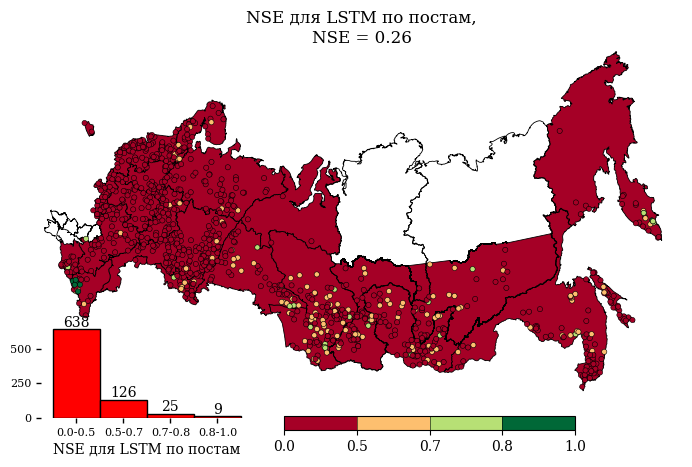

In [21]:
lstm_single_table, lstm_single_nse = read_table_gauge_str(
    table_path="/app/conclusions/tables/Single_LSTM_table.csv", index_filter=common_index
)

lstm_single_geom_nse = gauges_file.loc[:, ["geometry"]]

lstm_single_geom_nse.loc[:, ["NSE LSTM по постам"]] = pd.concat(
    [lstm_single_table.loc[common_index, "NSE"]],
    axis=1,
).values
lstm_single_geom_nse = lstm_single_geom_nse.dropna()


for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_single_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_single_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["NSE LSTM по постам"]] = ugms_part[["NSE LSTM по постам"]].median()

basin_districts.loc[[26, 27], ["NSE LSTM по постам"]] = np.nan

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_single_geom_nse,
    basemap_data=basemap_data,
    figsize=(10, 5),
    nrows=1,
    ncols=1,
    label_list=[""],
    columns_from_gdf=["NSE LSTM по постам"],
    hist_name=["NSE для LSTM по постам"],
    with_histogram=True,
    title_text=[f"NSE для LSTM по постам,\nNSE = {lstm_single_nse:.2f}"],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


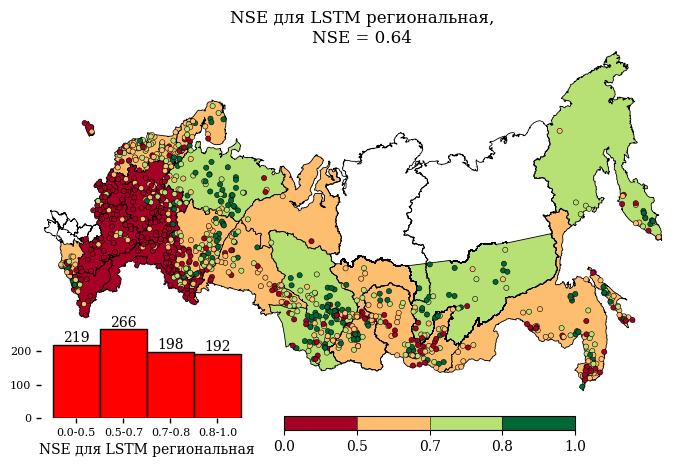

In [22]:
lstm_regional_table, lstm_regional_nse = read_table_gauge_str(
    table_path="/app/conclusions/tables/cudalstm_q_mm_day_mswep_res.csv", index_filter=common_index
)
common_index = common_index.intersection(lstm_regional_table.index)
lstm_regional_geom_nse = gauges_file.loc[common_index, ["geometry"]]

lstm_regional_geom_nse.loc[:, ["NSE LSTM региональная"]] = pd.concat(
    [lstm_regional_table.loc[common_index, "NSE"]],
    axis=1,
).values
lstm_regional_geom_nse = lstm_regional_geom_nse.dropna()


for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_regional_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_regional_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["NSE LSTM региональная"]] = ugms_part[["NSE LSTM региональная"]].median()

basin_districts.loc[[26, 27], ["NSE LSTM региональная"]] = np.nan

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_regional_geom_nse,
    basemap_data=basemap_data,
    figsize=(10, 5),
    nrows=1,
    ncols=1,
    label_list=[""],
    columns_from_gdf=["NSE LSTM региональная"],
    hist_name=["NSE для LSTM региональная"],
    with_histogram=True,
    title_text=[f"NSE для LSTM региональная,\nNSE = {lstm_regional_nse:.2f}"],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


In [23]:
lstm_s = pd.concat(
    [
        lstm_regional_table.median().to_frame().T,
        lstm_single_table.median().to_frame().T,
        lstm_vanila_table.median().to_frame().T,
    ]
)

lstm_s.index = pd.Index(["LSTM-региональная", "LSTM-по постам", "LSTM-без физ. гео."])

lstm_s.to_excel("/app/conclusions/tables/lstm_s_statistics.xlsx", float_format="%.2f")


### LSTM-ERA5, LSTM-MSWEP, LSTM-ERA5-Land, LSTM-GPCP

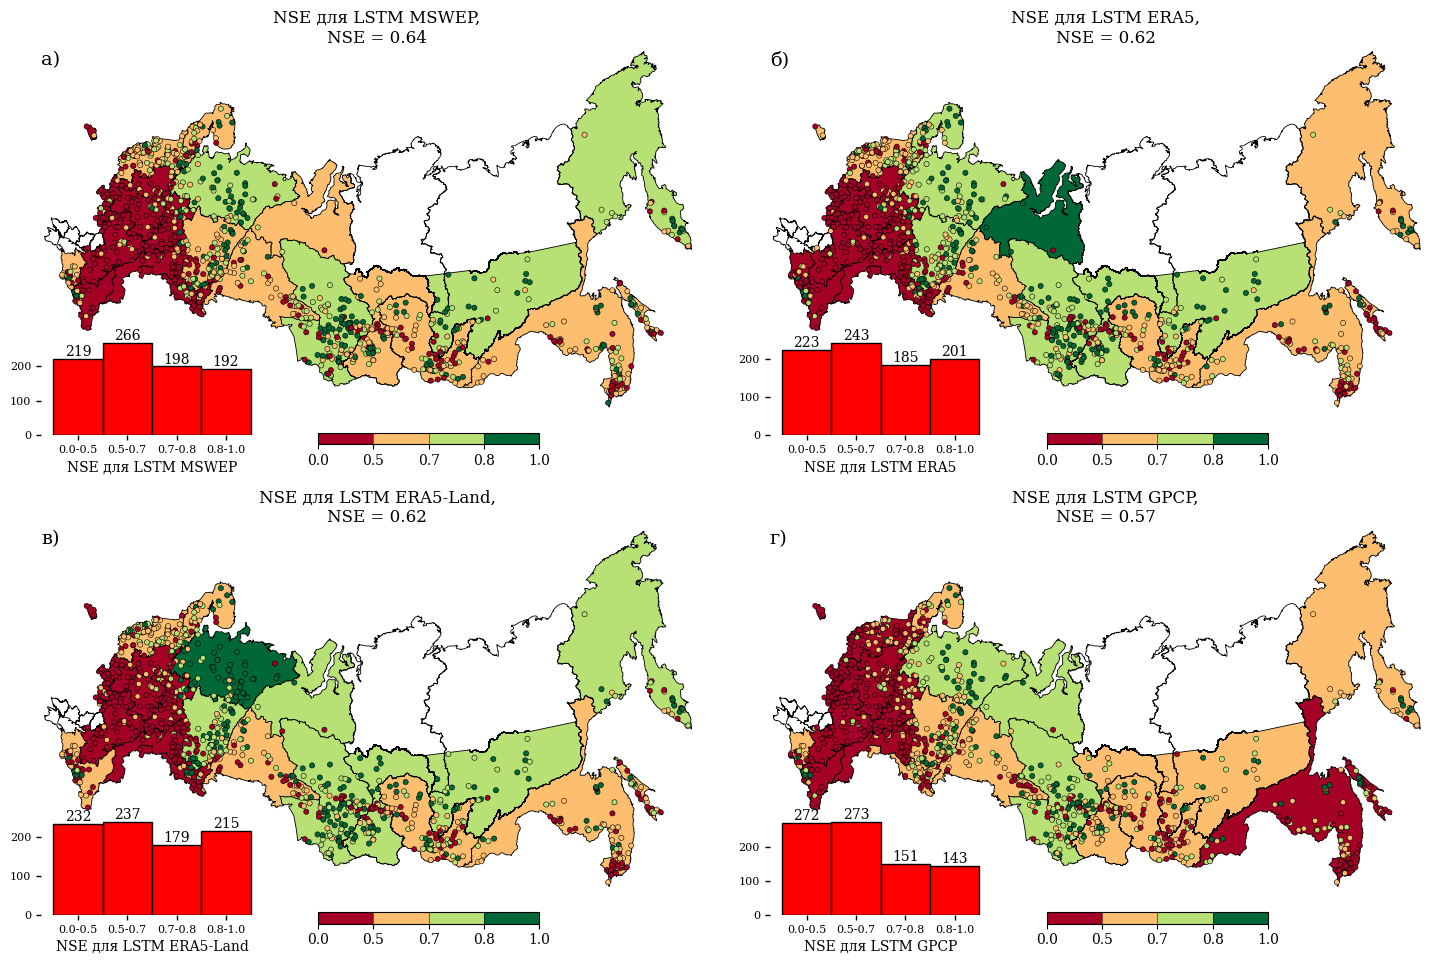

In [24]:
lstm_mswep_table, lstm_mswep_nse = read_table_gauge_str(
    table_path="/app/conclusions/tables/cudalstm_q_mm_day_mswep_res.csv", index_filter=common_index
)
lstm_era5_table, lstm_era5_nse = read_table_gauge_str(
    table_path="/app/conclusions/tables/cudalstm_q_mm_day_era5_res.csv", index_filter=common_index
)
lstm_era5_land_table, lstm_era5_land_nse = read_table_gauge_str(
    table_path="/app/conclusions/tables/cudalstm_q_mm_day_era5l_res.csv", index_filter=common_index
)
lstm_gpcp_table, lstm_gpcp_nse = read_table_gauge_str(
    table_path="/app/conclusions/tables/cudalstm_q_mm_day_gpcp_res.csv", index_filter=common_index
)
common_index = common_index.intersection(lstm_gpcp_table.index)
lstm_geom_nse = gauges_file.loc[common_index, ["geometry"]]

lstm_geom_nse.loc[:, ["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]] = (
    pd.concat(
        [
            lstm_mswep_table.loc[common_index, "NSE"],
            lstm_era5_table.loc[common_index, "NSE"],
            lstm_era5_land_table.loc[common_index, "NSE"],
            lstm_gpcp_table.loc[common_index, "NSE"],
        ],
        axis=1,
    ).values
)
lstm_geom_nse = lstm_geom_nse.dropna()

for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[
        i, ["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]
    ] = ugms_part[["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]].median()

basin_districts.loc[
    [26, 27], ["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]
] = np.nan

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_geom_nse,
    basemap_data=basemap_data,
    figsize=(15, 10),
    nrows=2,
    ncols=2,
    label_list=["а)", "б)", "в)", "г)"],
    columns_from_gdf=["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"],
    hist_name=["NSE для LSTM MSWEP", "NSE для LSTM ERA5", "NSE для LSTM ERA5-Land", "NSE для LSTM GPCP"],
    with_histogram=True,
    title_text=[
        f"NSE для LSTM MSWEP,\nNSE = {lstm_mswep_nse:.2f}",
        f"NSE для LSTM ERA5,\nNSE = {lstm_era5_nse:.2f}",
        f"NSE для LSTM ERA5-Land,\nNSE = {lstm_era5_land_nse:.2f}",
        f"NSE для LSTM GPCP,\nNSE = {lstm_gpcp_nse:.2f}",
    ],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


#### Get best NSE for each gauge for each meteo input

In [58]:
lstm_geom_nse["best NSE"] = lstm_geom_nse[
    ["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]
].max(axis=1)
mswep_index = lstm_geom_nse[lstm_geom_nse["best NSE"].isin(lstm_geom_nse["NSE LSTM MSWEP"])].index
era5_index = lstm_geom_nse[lstm_geom_nse["best NSE"].isin(lstm_geom_nse["NSE LSTM ERA5"])].index
era5_land_index = lstm_geom_nse[
    lstm_geom_nse["best NSE"].isin(lstm_geom_nse["NSE LSTM ERA5-Land"])
].index
gpcp_index = lstm_geom_nse[lstm_geom_nse["best NSE"].isin(lstm_geom_nse["NSE LSTM GPCP"])].index

for name, index in {
    "MSWEP": mswep_index,
    "ERA5": era5_index,
    "ERA5-Land": era5_land_index,
    "GPCP": gpcp_index,
}.items():
    lstm_geom_nse.loc[index, "Лучшая модель"] = name


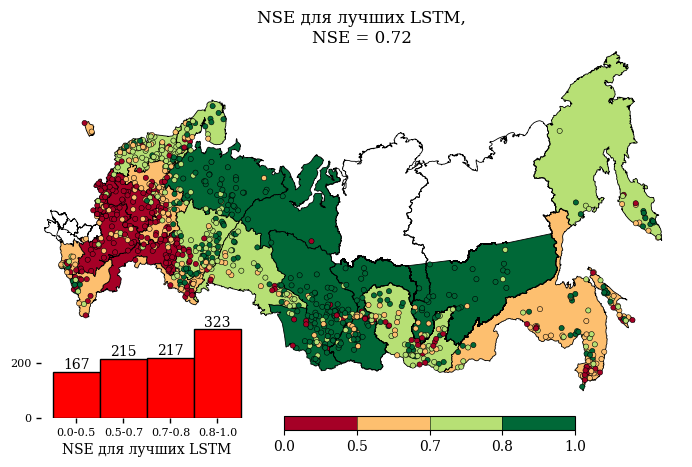

In [48]:
for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["best NSE"]] = ugms_part[["best NSE"]].median()

basin_districts.loc[[26, 27], ["best NSE"]] = np.nan

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_geom_nse,
    basemap_data=basemap_data,
    figsize=(10, 5),
    nrows=1,
    ncols=1,
    label_list=[""],
    columns_from_gdf=["best NSE"],
    hist_name=["NSE для лучших LSTM"],
    with_histogram=True,
    title_text=[f"NSE для лучших LSTM,\nNSE = {lstm_geom_nse['best NSE'].median():.2f}"],
    ugms=True,
    ugms_gdf=basin_districts.sort_index(),
)


In [28]:
model_dict = {"MSWEP": 1, "ERA5-Land": 2, "ERA5": 3, "GPCP": 4, "Неоднозначно": 5, np.nan: np.nan}
cool_model = np.nan
for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]
    try:
        example = ugms_part["Лучшая модель"].value_counts()

        for model, value in example.items():
            if value / example.sum() > 0.33:
                cool_model = model
                break
            else:
                cool_model = "Неоднозначно"
        # basin_districts.loc[i, ["Лучшая модель"]] = ugms_part["Лучшая модель"].value_counts().index[0]
        # basin_districts.loc[i, ["Лучшая модель"]] = model_dict[
        #     ugms_part["Лучшая модель"].value_counts().index[0]
        # ]
        basin_districts.loc[i, ["Лучшая модель"]] = model_dict[cool_model]

        lstm_geom_nse.loc[
            [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], ["Лучшая модель"]
        ] = cool_model
    except IndexError:
        basin_districts.loc[i, ["Лучшая модель"]] = np.nan
basin_districts.loc[[26, 27], ["Лучшая модель"]] = np.nan
lstm_geom_nse["Лучшая модель"] = [model_dict[i] for i in lstm_geom_nse["Лучшая модель"]]


In [ ]:
gdf_to_plot = lstm_geom_nse
basemap_data = basemap_data
figsize = (10, 5)
nrows = 1
ncols = 1
label_list = [""]
list_of_limits = [1, 2, 3, 4, 5, 6]
columns_from_gdf = ["Лучшая модель"]
hist_name = ["Лучшая модель по БО"]
with_histogram = True
just_points = False
title_text = [f"NSE для лучших LSTM,\nNSE = {lstm_geom_nse['best NSE'].median():.2f}"]
ugms = True
ugms_gdf = basin_districts
cmap_lims: tuple = (0, 1)
cmap_name: str = "RdYlGn"
rus_extent: list = [50, 140, 32, 90]

# RUSSIA
aea_crs = ccrs.AlbersEqualArea(
    central_longitude=100,
    standard_parallels=(50, 70),
    central_latitude=56,
    false_easting=0,
    false_northing=0,
)
# to proj4 form
aea_crs_proj4 = aea_crs.proj4_init

fig, axs = plt.subplots(figsize=figsize, ncols=ncols, nrows=nrows, subplot_kw={"projection": aea_crs})

for i, ax in enumerate(np.ravel(axs)):
    cmap = cm.get_cmap(cmap_name, len(list_of_limits) - 1)
    vmin, vmax = cmap_lims
    # [-100, -75, -50, -25, 0, 25, 50, 75, 100]
    # [0.0, 0.50, 0.70, 0.80, 1.00]
    # bounds = [-100, -75, -50, -25, 0, 25, 50, 75, 100]

    norm_cmap = mpl.colors.BoundaryNorm(list_of_limits, len(list_of_limits) - 1)
    # norm_cmap = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    if i >= len(columns_from_gdf):
        ax.set_visible(False)
        break
    # plot settings
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_extent(rus_extent)  # type: ignore
    if not ugms:
        # plot russia basemap
        basemap_data.to_crs(aea_crs_proj4).plot(  # type: ignore
            ax=ax,
            color="grey",
            edgecolor="black",
            legend=False,
            alpha=0.8,
            linewidth=0.6,
        )
    gdf_to_plot = gdf_to_plot.to_crs(aea_crs_proj4)  # type: ignore
    # plot variable
    if just_points:
        scatter_plot = gdf_to_plot.plot(
            ax=ax,
            column=columns_from_gdf[i],
            cmap=cmap,
            norm=norm_cmap,
            marker="o",
            markersize=10,
            legend=True,
            legend_kwds={
                "loc": "lower center",
                "ncol": 2,
                "fmt": "{:.0f}",
                "fontsize": 8,
            },
        )
    else:
        if ugms:
            ugms_gdf.to_crs(aea_crs_proj4).plot(
                ax=ax,
                column=columns_from_gdf[i],
                cmap=cmap,
                norm=norm_cmap,
                legend=False,
                edgecolor="black",
                linewidth=0.6,
                # missing_kwds=dict(color="black", aspect="equal"),
                missing_kwds={"color": "#DF60DF00"},
                legend_kwds={
                    "loc": "lower center",
                    "ncol": 2,
                    "fmt": "{:.0f}",
                    "fontsize": 8,
                },
            )
        scatter_plot = gdf_to_plot.plot(
            ax=ax,
            column=columns_from_gdf[i],
            cmap=cmap,
            norm=norm_cmap,
            marker="o",
            markersize=14,
            edgecolor="black",
            linewidth=0.4,
            legend=True,
            legend_kwds={
                "orientation": "horizontal",
                "shrink": 0.3,
                "pad": -0.05,
                "anchor": (0.6, 0.5),
                "drawedges": True,
            },
            # legend_kwds={
            #     "loc": "lower center",
            #     "ncol": 2,
            #     "fmt": "{:.0f}",
            #     "fontsize": 8,
            # },
        )
    ax.text(
        0,
        1,
        label_list[i],
        ha="left",
        va="top",
        transform=ax.transAxes,
        fontsize=14,
    )
    my_fig = scatter_plot.figure
    if not just_points:
        try:
            cb_ax = my_fig.axes[nrows * ncols + i]
        except IndexError:
            cb_ax = my_fig.axes[0]
        cb_ax.tick_params(labelsize=10)

    if with_histogram:
        if just_points:
            hist_df = pd.DataFrame()
            for qual, idx in gdf_to_plot.groupby(f"{columns_from_gdf[i]}").groups.items():
                hist_df.loc[0, f"{qual}"] = len(idx)
        else:
            hist_df = pd.crosstab(
                gdf_to_plot[columns_from_gdf[i]],  # type: ignore
                pd.cut(
                    gdf_to_plot[columns_from_gdf[i]],  # type: ignore
                    list_of_limits,
                    include_lowest=False,
                ),
            )

        hist_df = hist_df.reset_index(drop=True)
        hist_df.columns.name = hist_name[i]
        # x of borders, y of borders, weight, height
        ax_hist = ax.inset_axes([0.00, 0.05, 0.33, 0.24])
        extra_hist = hist_df.sum(axis=0).plot.bar(
            ax=ax_hist, rot=0, width=1, facecolor="red", edgecolor="black", lw=1
        )
        extra_hist.bar_label(extra_hist.containers[0], fmt="%.0f")
        extra_hist.set_facecolor("white")
        extra_hist.tick_params(width=1)
        extra_hist.grid(False)

        if just_points:
            xlbl = [str(col).replace(", ", "-") for col in hist_df.columns]
        else:
            xlbl = [str(col)[1:-1].replace(", ", "-") for col in hist_df.columns]
        if len(xlbl) > 4:
            xlbl = [lbl if not (i % 2) else "" for i, lbl in enumerate(xlbl)]

        ax_hist.set(frame_on=False)
        extra_hist.set_xticklabels(xlbl)

        plt.setp(ax_hist.get_xticklabels(), fontsize=8)
        plt.setp(ax_hist.get_yticklabels(), fontsize=8)
    ax.set_title(f"{title_text[i]}", fontdict={"size": 12})
    plt.tight_layout()

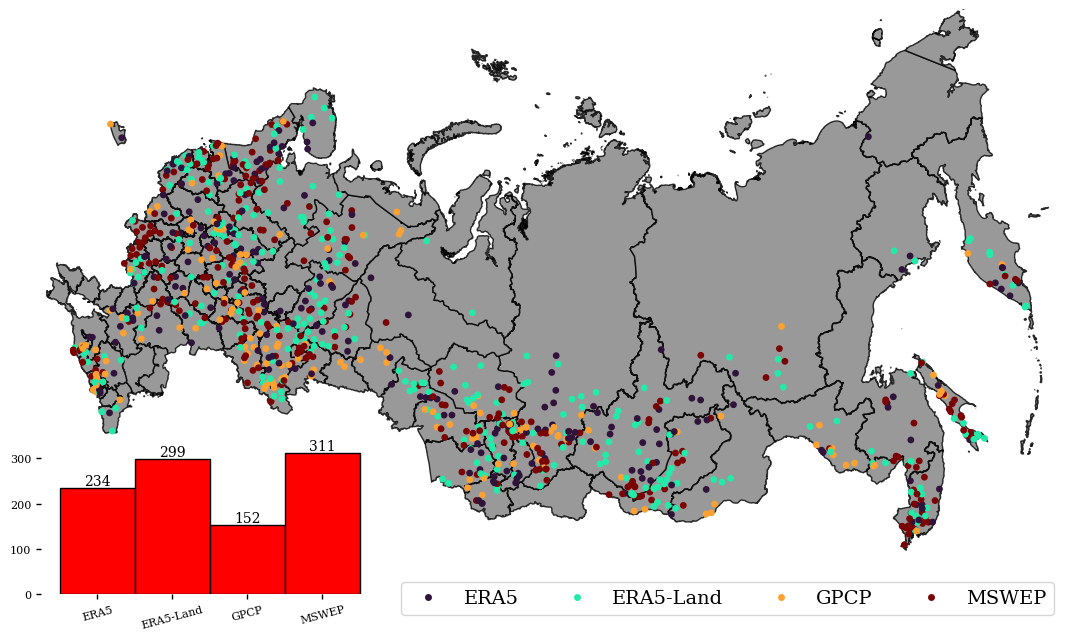

In [50]:
for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]
    try:
        example = ugms_part["Лучшая модель"].value_counts()
        for model, value in example.items():
            if value / example.sum() > 0.50:
                cool_model = model
                break
            else:
                cool_model = "Неоднозначно"
        basin_districts.loc[i, ["Лучшая модель"]] = ugms_part["Лучшая модель"].value_counts().index[0]
        # basin_districts.loc[i, ["Лучшая модель"]] = cool_model
        # lstm_geom_nse.loc[
        #     [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], ["Лучшая модель"]
        # ] = cool_model
    except IndexError:
        basin_districts.loc[i, ["Лучшая модель"]] = np.nan


basin_districts.loc[[26, 27], ["Лучшая модель"]] = np.nan

# meteo_nse = russia_plots_n(
#     gdf_to_plot=lstm_geom_nse,
#     basemap_data=basemap_data,
#     figsize=(10, 5),
#     nrows=1,
#     ncols=1,
#     label_list=[""],
#     list_of_limits=[0, 1, 2, 3, 4],
#     columns_from_gdf=["Лучшая модель"],
#     hist_name=["Лучшая модель по БО"],
#     with_histogram=True,
#     title_text=[f"NSE для лучших LSTM,\nNSE = {lstm_geom_nse['best NSE'].median():.2f}"],
#     ugms=True,
#     ugms_gdf=basin_districts,
# )
gauges_fig = russia_plots(
    gdf_to_plot=lstm_geom_nse,
    basemap_data=basemap_data,
    distinction_col="Лучшая модель",
    cmap_name="turbo",
    list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True,
    legend_cols=4,
    with_histogram=True,
)


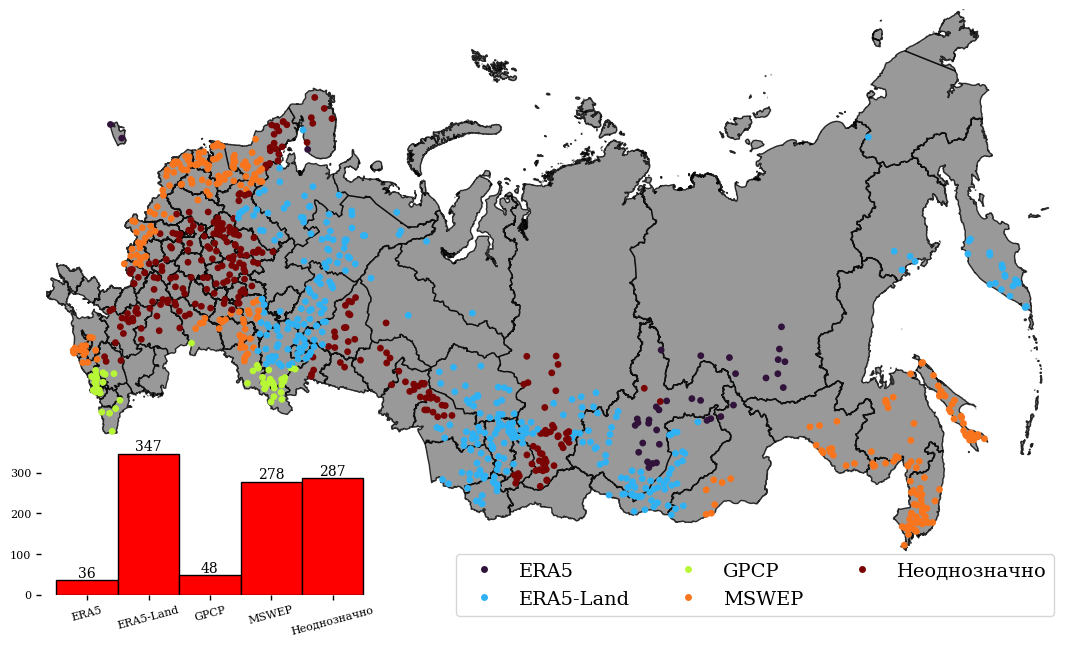

In [51]:
lstm_geom_nse_type = deepcopy(lstm_geom_nse)

model_dict = {"MSWEP": 1, "ERA5-Land": 2, "ERA5": 3, "GPCP": 4, "Неоднозначно": 5, np.nan: np.nan}
cool_model = np.nan
for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse_type.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse_type["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]
    try:
        example = ugms_part["Лучшая модель"].value_counts()

        for model, value in example.items():
            if value / example.sum() > 0.33:
                cool_model = model
                break
            else:
                cool_model = "Неоднозначно"

        # basin_districts.loc[i, ["Лучшая модель"]] = ugms_part["Лучшая модель"].value_counts().index[0]
        # basin_districts.loc[i, ["Лучшая модель"]] = model_dict[
        #     ugms_part["Лучшая модель"].value_counts().index[0]
        # ]
        basin_districts.loc[i, ["Лучшая модель"]] = model_dict[cool_model]
        lstm_geom_nse_type.loc[
            [geom.intersects(gage_point) for gage_point in lstm_geom_nse_type["geometry"]],
            ["Лучшая модель"],
        ] = cool_model
    except IndexError:
        basin_districts.loc[i, ["Лучшая модель"]] = np.nan
basin_districts.loc[[26, 27], ["Лучшая модель"]] = np.nan
# lstm_geom_nse_type["Лучшая модель"] = [model_dict[i] for i in lstm_geom_nse_type["Лучшая модель"]]

gauges_fig = russia_plots(
    gdf_to_plot=lstm_geom_nse_type,
    basemap_data=basemap_data,
    distinction_col="Лучшая модель",
    cmap_name="turbo",
    list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True,
    legend_cols=3,
    with_histogram=True,
)


In [197]:
for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[i, ["best NSE"]] = ugms_part[["best NSE"]].median()
    basin_districts.loc[i, ["Количество точек"]] = int(len(ugms_part))

basin_districts.loc[[26, 27], ["best NSE"]] = np.nan


In [218]:
basin_to_excel = basin_districts.drop(
    columns=[
        "path",
        "geometry",
        "NSE LSTM региональная",
        "best NSE",
        "Лучшая модель",
        "NSE Random Forest",
        "NSE LSTM по постам",
        "layer",
        "NSE LSTM MSWEP",
        "NSE LSTM ERA5",
        "NSE LSTM ERA5-Land",
        "NSE LSTM GPCP",
    ]
).dropna()

basin_to_excel = basin_to_excel.set_index("name1")
basin_to_excel.index.name = "Бассейновый округ"
basin_to_excel = basin_to_excel.loc[
    :,
    [
        "NSE LSTM-лучшие",
        "NSE Cлучайный лес",
        "NSE GR4J",
        "NSE LSTM без физ. гео.",
        "NSE HBV",
        "NSE LSTM-по постам",
        "Количество точек",
    ],
]
# basin_to_excel.to_excel("/app/conclusions/tables/nse_bys")
# apply some formatting for all numbers (optional)
df_s = basin_to_excel.style.format("{:.2f}")
# df_s = df_s.loc[:, ["Количество точек"]].style.format("{:.0f}")
# loop through rows and find which column for each row has the highest value
for row in basin_to_excel.index:
    col = basin_to_excel.loc[
        row,
        [
            "NSE LSTM-лучшие",
            "NSE Cлучайный лес",
            "NSE GR4J",
            "NSE LSTM без физ. гео.",
            "NSE HBV",
            "NSE LSTM-по постам",
        ],
    ].idxmax()
    # redo formatting for a specific cell
    df_s = df_s.format(lambda x: "\\textbf{" + f"{x:.3f}" + "}", subset=(row, col))
df_s.to_excel("/app/conclusions/tables/NSE_by_basin_district.xlsx")
df_s

In [217]:
pd.read_excel("/app/conclusions/tables/NSE_by_basin_district.xlsx")

Бассейновый округ  NSE LSTM-лучшие  NSE Cлучайный лес  NSE GR4J  \
0       Двинско-Печорский         0.846606           0.615658  0.663559   
1              Балтийский         0.724352           0.514734  0.436342   
2      Ангаро-Байкальский         0.753345           0.625676  0.560578   
3   Баренцево-Беломорский         0.795349           0.601510  0.524841   
4                Амурский         0.690661           0.559153  0.559645   
5          Ленский. обрез         0.824518           0.779438  0.631016   
6           Нижневолжский         0.290991          -0.014293 -0.955572   
7                 Камский         0.778444           0.528934  0.556206   
8               Иртышский         0.758065           0.465375  0.158369   
9       Енисейский. обрез         0.801615           0.718810  0.560222   
10                Донской         0.273684           0.575028 -0.825316   
11     Западно-Каспийский         0.616862           0.628288  0.294314   
12            Днепровский         0.326021           0.486377 -1.034521   
13              Уральский         0.554971          -0.165233 -0.082574   
14              Кубанский         0.643506           0.543729  0.370058   
15         Верхневолжский         0.541797           0.280596  0.428484   
16                 Окский         0.404541           0.232822 -0.222496   
17      Анадыро-Колымский         0.763874           0.764283  0.528120   
18            Нижнеобский         0.833413           0.686037  0.571743   
19           Верхнеобский         0.849142           0.666523  0.424764   
20            Калининград         0.575116          -0.313594 -0.222558   

    NSE LSTM без физ. гео.   NSE HBV  NSE LSTM-по постам  Количество точек  
0                 0.695869  0.662792            0.266056                56  
1                 0.354571  0.445391            0.200385                88  
2                 0.430187  0.486312            0.380083                78  
3                 0.438953  0.443941            0.343924                25  
4                 0.468484  0.462461            0.243471               113  
5                 0.541015  0.609596            0.428881                35  
6                -0.148150 -2.161584           -0.052515                32  
7                 0.570572  0.432099            0.245772                76  
8                 0.523232  0.039787            0.275648                51  
9                 0.582178  0.536881            0.386582                53  
10               -0.437229 -1.660193           -0.148153                55  
11               -0.288013  0.200916            0.398626                22  
12                0.149556 -0.992689           -0.263715                28  
13                0.262503  0.184173            0.293077                26  
14                0.331191  0.271083            0.169252                17  
15                0.361621  0.292409            0.034664                73  
16                0.218692 -0.286828           -0.080500                28  
17                0.544480  0.474788            0.406670                26  
18                0.602299  0.510346            0.353482                 3  
19                0.486329  0.371825            0.443473               107  
20                0.098978 -0.310882           -0.152333                 2

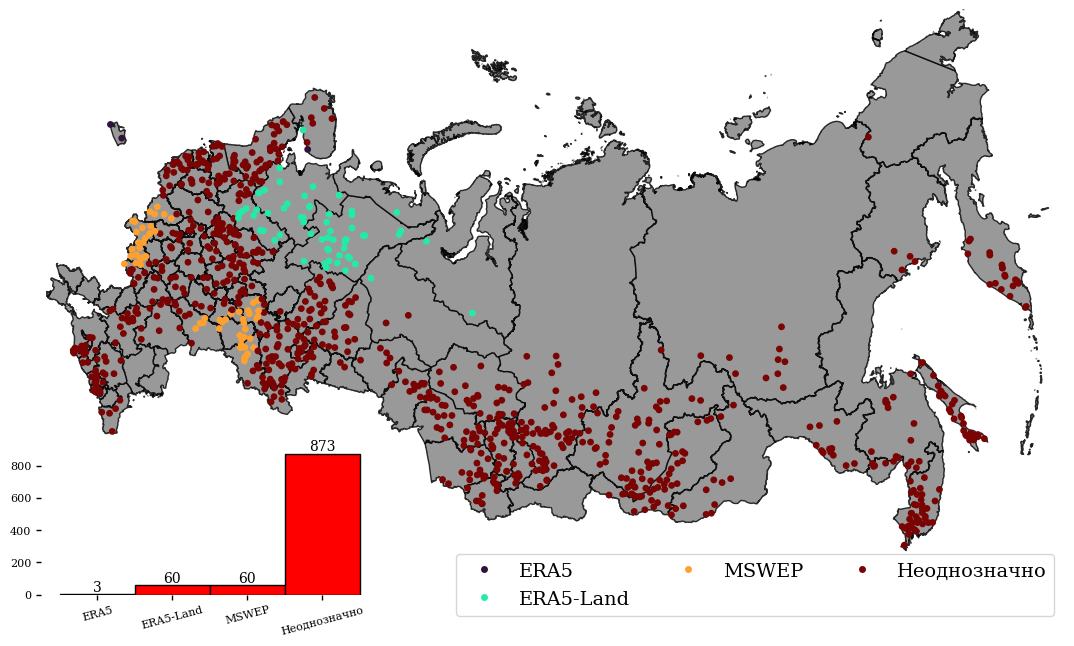

In [63]:
lstm_geom_nse_type = deepcopy(lstm_geom_nse)

model_dict = {"MSWEP": 1, "ERA5-Land": 2, "ERA5": 3, "GPCP": 4, "Неоднозначно": 5, np.nan: np.nan}
cool_model = np.nan
for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse_type.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse_type["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]
    try:
        example = ugms_part["Лучшая модель"].value_counts()

        for model, value in example.items():
            if value / example.sum() > 0.40:
                cool_model = model
                break
            else:
                cool_model = "Неоднозначно"

        # basin_districts.loc[i, ["Лучшая модель"]] = ugms_part["Лучшая модель"].value_counts().index[0]
        # basin_districts.loc[i, ["Лучшая модель"]] = model_dict[
        #     ugms_part["Лучшая модель"].value_counts().index[0]
        # ]
        basin_districts.loc[i, ["Лучшая модель"]] = model_dict[cool_model]
        lstm_geom_nse_type.loc[
            [geom.intersects(gage_point) for gage_point in lstm_geom_nse_type["geometry"]],
            ["Лучшая модель"],
        ] = cool_model
    except IndexError:
        basin_districts.loc[i, ["Лучшая модель"]] = np.nan
basin_districts.loc[[26, 27], ["Лучшая модель"]] = np.nan
# lstm_geom_nse_type["Лучшая модель"] = [model_dict[i] for i in lstm_geom_nse_type["Лучшая модель"]]

gauges_fig = russia_plots(
    gdf_to_plot=lstm_geom_nse_type,
    basemap_data=basemap_data,
    distinction_col="Лучшая модель",
    cmap_name="turbo",
    list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True,
    legend_cols=3,
    with_histogram=True,
)


In [64]:
lstm_best_table = pd.concat(
    [
        lstm_mswep_table.loc[mswep_index, :],
        lstm_era5_land_table.loc[era5_land_index, :],
        lstm_era5_table.loc[era5_index, :],
        lstm_gpcp_table.loc[gpcp_index, :],
    ]
)

lstm_s_meteo = pd.concat(
    [
        lstm_mswep_table.median().to_frame().T,
        lstm_era5_table.median().to_frame().T,
        lstm_era5_land_table.median().to_frame().T,
        lstm_gpcp_table.median().to_frame().T,
        lstm_best_table.median().to_frame().T,
    ]
)

lstm_s_meteo.index = pd.Index(["LSTM MSWEP", "LSTM ERA5", "LSTM ERA5-Land", "LSTM GPCP", "Лучшие LSTM"])

lstm_s_meteo.to_excel("/app/conclusions/tables/lstm_s_meteo_statistics.xlsx", float_format="%.2f")


In [67]:
final_table = list()


def table_statistics(table: pd.DataFrame, table_name: str):
    nse_row = pd.DataFrame()
    nse_row.loc[table_name, "Постов в исследовании"] = f"{table['NSE'].__len__():.0f}"
    nse_row.loc[table_name, "NSE медиана"] = f"{(table['NSE'].median()):.2f}"
    nse_row.loc[table_name, "NSE < 0.5"] = f"{(table['NSE'] < 0.5).sum():.0f}"
    nse_row.loc[table_name, "NSE < 0"] = f"{(table['NSE'] < 0).sum():.0f}"
    nse_row.loc[table_name, "NSE > 0.5"] = f"{((table['NSE'] > 0.5).sum()):.0f}"
    nse_row.loc[table_name, "NSE удовл., %"] = (
        f"{((table['NSE'] > 0.5).sum() / table['NSE'].__len__()):.1%}"
    )

    return nse_row


table_dict = {
    "HBV": hbv_table.loc[common_index, :],
    "GR4J": gr4j_table.loc[common_index, :],
    "Случайный лес": rfr_table.loc[common_index, :],
    "LSTM MSWEP": lstm_regional_table.loc[common_index, :],
    "LSTM-по постам": lstm_single_table.loc[common_index, :],
    "LSTM без физ.гео.": lstm_vanila_table.loc[common_index, :],
    "LSTM лучшие": lstm_best_table.loc[common_index, :],
}

for name, table in table_dict.items():
    final_table.append(table_statistics(table=table, table_name=name))
final_table = pd.concat(final_table)
final_table = final_table.sort_values(by="NSE медиана", ascending=False)
final_table.to_excel("/app/conclusions/tables/nse_table_result.xlsx", float_format="%.2f")
final_table


Постов в исследовании NSE медиана NSE < 0.5 NSE < 0  \
LSTM лучшие                         996        0.72       241      74   
LSTM MSWEP                          996        0.64       340     121   
Случайный лес                       996        0.56       405     123   
GR4J                                996        0.44       572     206   
LSTM без физ.гео.                   996        0.43       607     219   
HBV                                 996        0.36       643     271   
LSTM-по постам                      996        0.26       836     199   

                  NSE > 0.5 NSE удовл., %  
LSTM лучшие             755         75.8%  
LSTM MSWEP              656         65.9%  
Случайный лес           591         59.3%  
GR4J                    424         42.6%  
LSTM без физ.гео.       389         39.1%  
HBV                     353         35.4%  
LSTM-по постам          160         16.1%

### HBV, GR4J, LSTM-regional, LSTM-single, LSTM-vanila, Random Forest

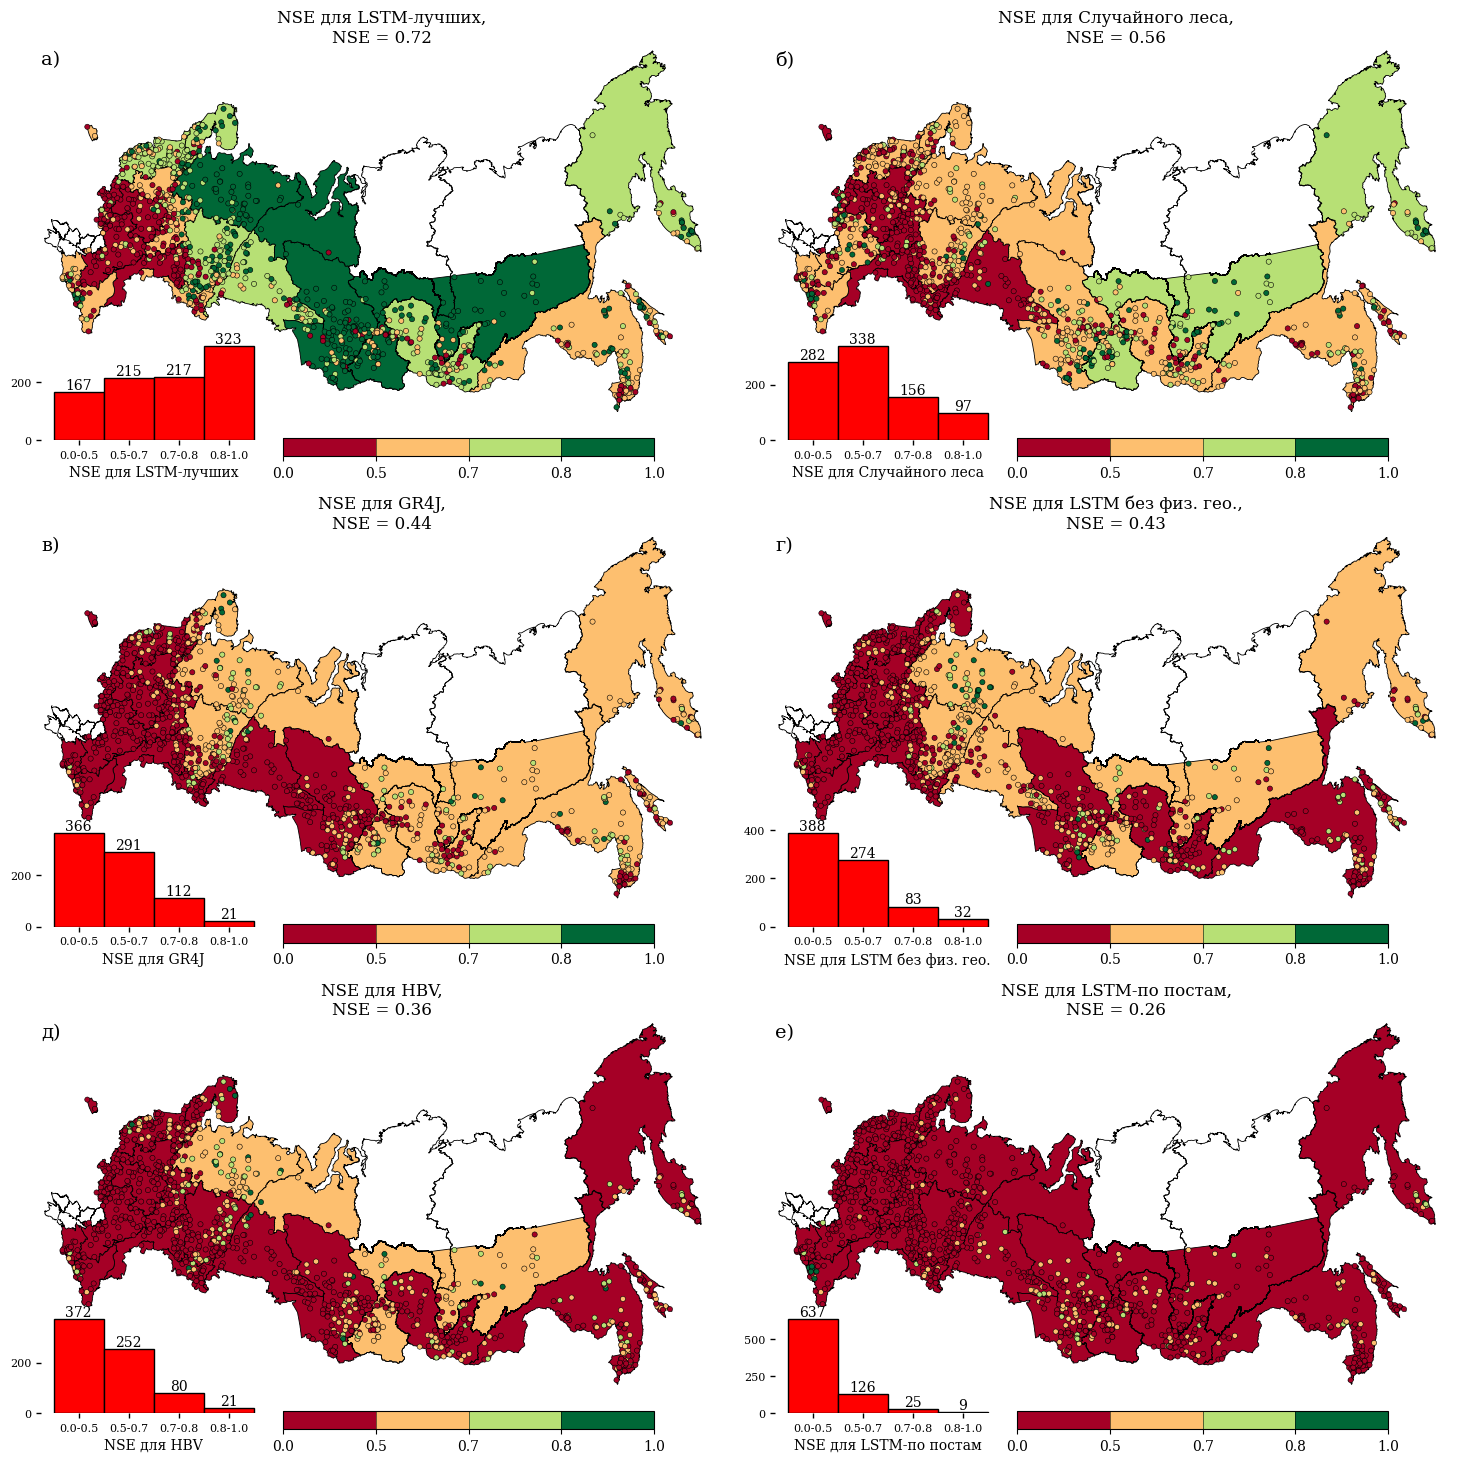

In [69]:
lstm_geom_nse = gauges_file.loc[common_index, ["geometry"]]
lstm_best_nse = lstm_best_table.loc[common_index, "NSE"].median()

lstm_geom_nse.loc[
    :,
    [
        "NSE LSTM-лучшие",
        "NSE Cлучайный лес",
        "NSE GR4J",
        "NSE LSTM без физ. гео.",
        "NSE HBV",
        "NSE LSTM-по постам",
    ],
] = pd.concat(
    [
        lstm_best_table.loc[common_index, "NSE"],
        rfr_table.loc[common_index, "NSE"],
        gr4j_table.loc[common_index, "NSE"],
        lstm_vanila_table.loc[common_index, "NSE"],
        hbv_table.loc[common_index, "NSE"],
        lstm_single_table.loc[common_index, "NSE"],
    ],
    axis=1,
).values
lstm_geom_nse = lstm_geom_nse.dropna()

for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]

    basin_districts.loc[
        i,
        [
            "NSE LSTM-лучшие",
            "NSE Cлучайный лес",
            "NSE GR4J",
            "NSE LSTM без физ. гео.",
            "NSE HBV",
            "NSE LSTM-по постам",
        ],
    ] = ugms_part[
        [
            "NSE LSTM-лучшие",
            "NSE Cлучайный лес",
            "NSE GR4J",
            "NSE LSTM без физ. гео.",
            "NSE HBV",
            "NSE LSTM-по постам",
        ]
    ].median()

basin_districts.loc[
    [26, 27],
    [
        "NSE LSTM-лучшие",
        "NSE Cлучайный лес",
        "NSE GR4J",
        "NSE LSTM без физ. гео.",
        "NSE HBV",
        "NSE LSTM-по постам",
    ],
] = np.nan

meteo_nse = russia_plots_n(
    gdf_to_plot=lstm_geom_nse,
    basemap_data=basemap_data,
    figsize=(20, 15),
    nrows=3,
    ncols=2,
    label_list=["а)", "б)", "в)", "г)", "д)", "е)"],
    columns_from_gdf=[
        "NSE LSTM-лучшие",
        "NSE Cлучайный лес",
        "NSE GR4J",
        "NSE LSTM без физ. гео.",
        "NSE HBV",
        "NSE LSTM-по постам",
    ],
    hist_name=[
        "NSE для LSTM-лучших",
        "NSE для Cлучайного леса",
        "NSE для GR4J",
        "NSE для LSTM без физ. гео.",
        "NSE для HBV",
        "NSE для LSTM-по постам",
    ],
    with_histogram=True,
    title_text=[
        f"NSE для LSTM-лучших,\nNSE = {lstm_best_nse:.2f}",
        f"NSE для Cлучайного леса,\nNSE = {rfr_nse:.2f}",
        f"NSE для GR4J,\nNSE = {nse_gr4j:.2f}",
        f"NSE для LSTM без физ. гео.,\nNSE = {lstm_vanila_nse:.2f}",
        f"NSE для HBV,\nNSE = {nse_hbv:.2f}",
        f"NSE для LSTM-по постам,\nNSE = {lstm_single_nse:.2f}",
    ],
    ugms=True,
    ugms_gdf=basin_districts,
)


### Best 4, Worst 4

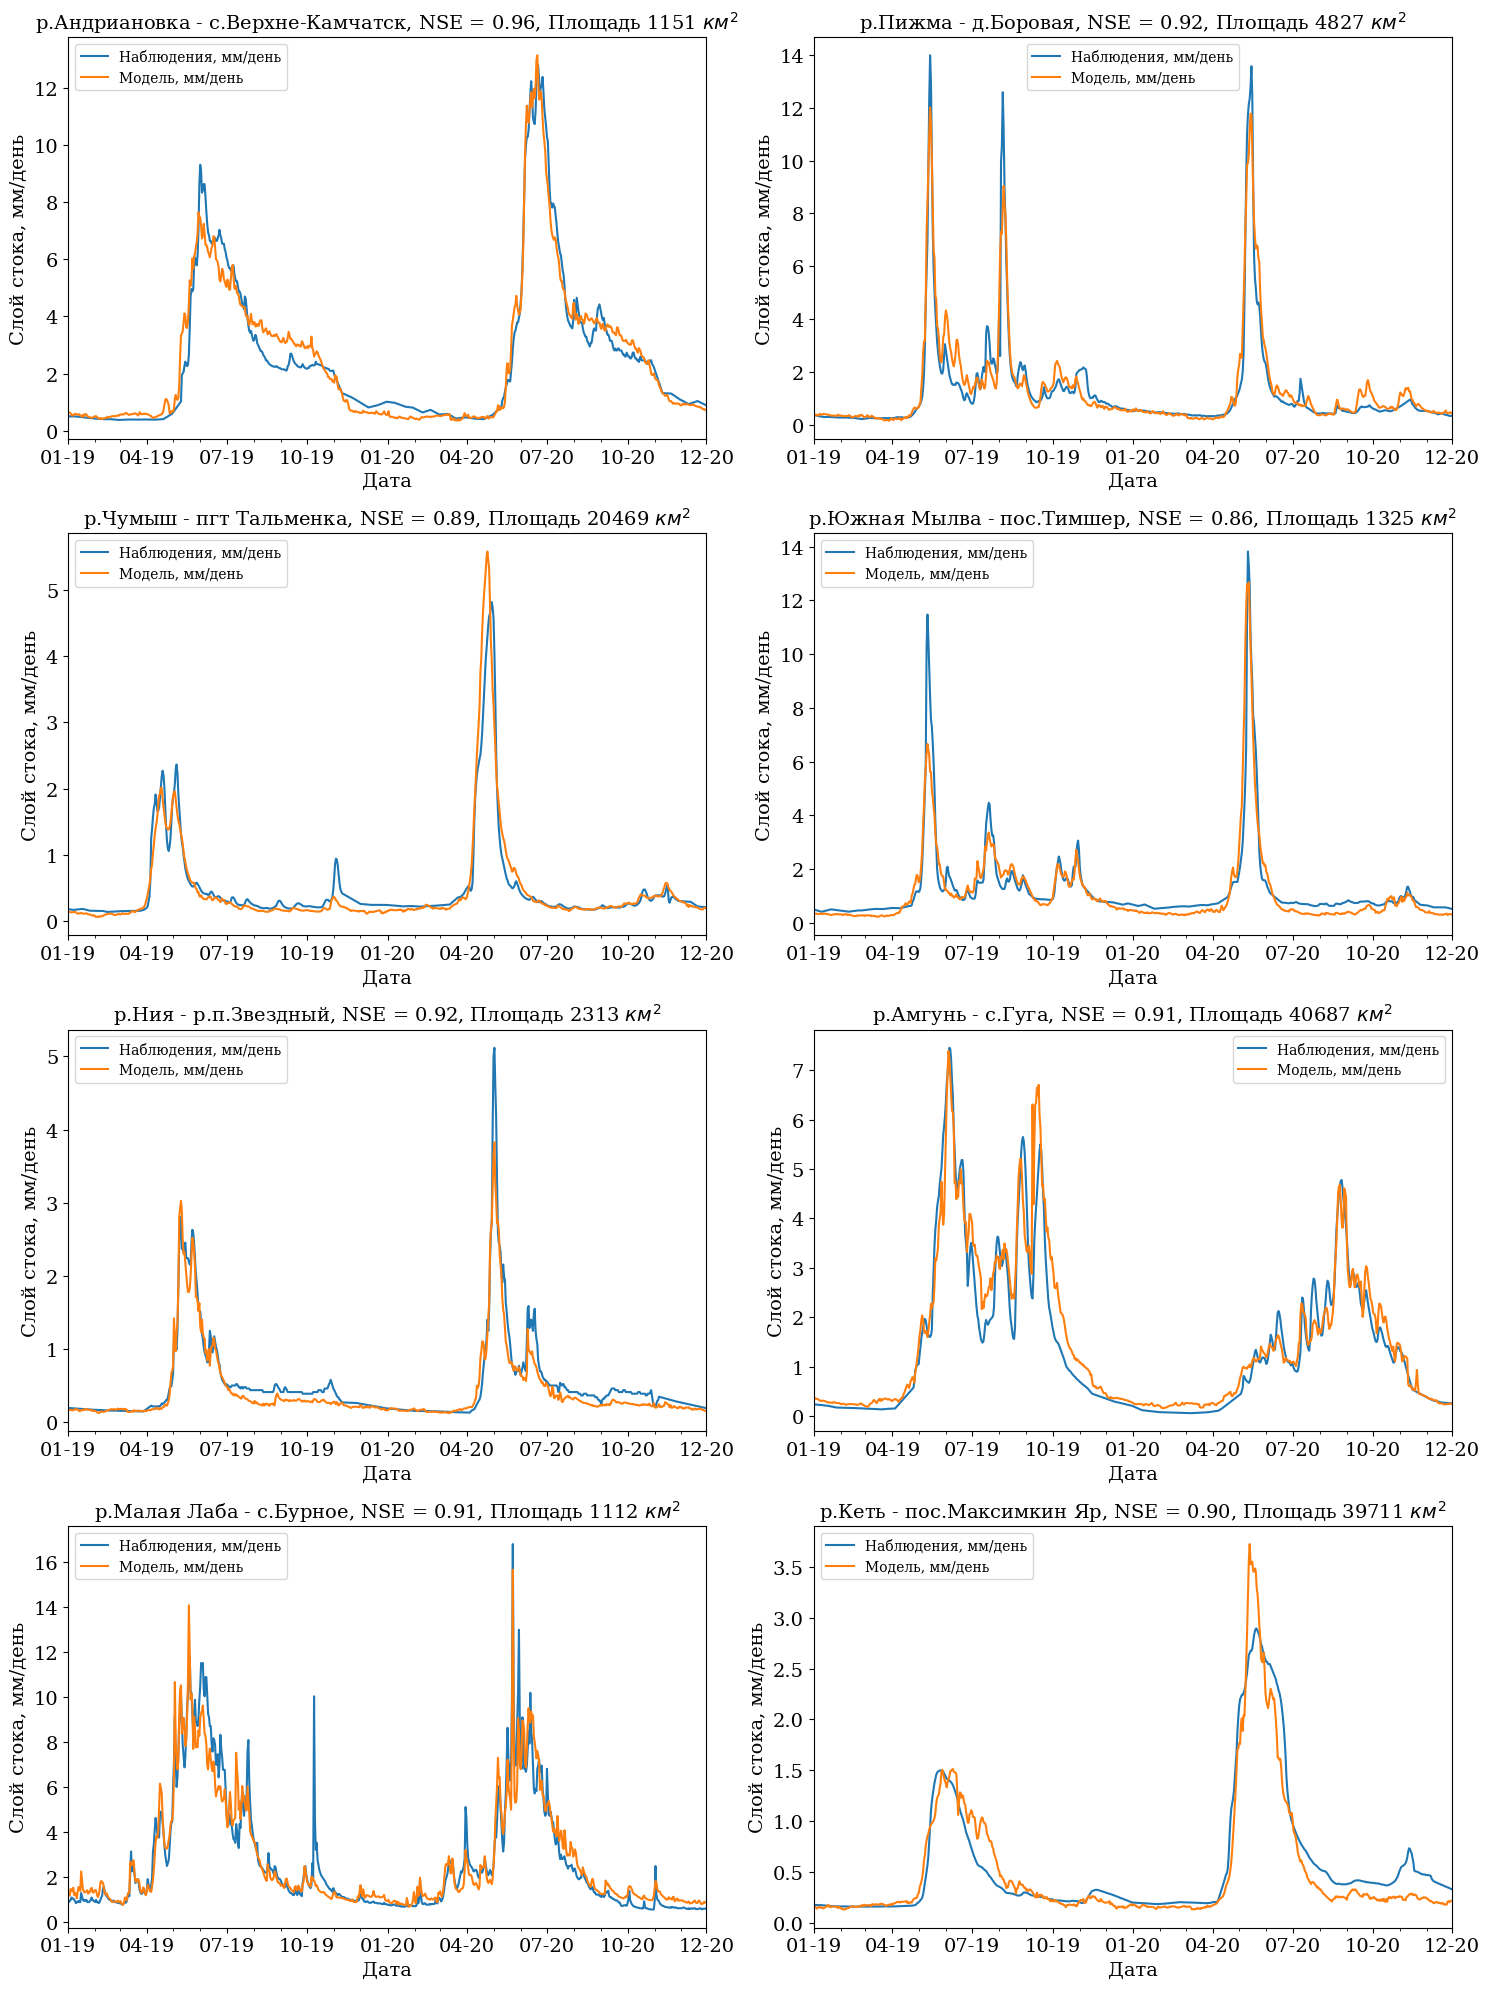

In [72]:
best_4 = lstm_best_table[lstm_best_table["NSE"] > 0.85].sample(n=8)

mswep_pickle = Path(
    "/app/data/lstm_configs/model_runs/cudalstm_q_mm_day_mswep_no_autocorr_static_1103_191754/test/model_epoch024/test_results.p"
)
gpcp_pickle = Path(
    "/app/data/lstm_configs/model_runs/cudalstm_q_mm_day_gpcp_no_autocorr_static_1203_080402/test/model_epoch024/test_results.p"
)
era5l_pickle = Path(
    "/app/data/lstm_configs/model_runs/cudalstm_q_mm_day_era5l_no_autocorr_static_1003_133332/test/model_epoch026/test_results.p"
)
era5_pickle = Path(
    "/app/data/lstm_configs/model_runs/cudalstm_q_mm_day_era5_no_autocorr_static_1203_220232/test/model_epoch020/test_results.p"
)

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

date_form = DateFormatter("%m-%y")

for gauge_id, ax in zip(best_4.index, np.ravel(axs)):
    if gauge_id in mswep_index:
        pickle_file = mswep_pickle
    elif gauge_id in gpcp_index:
        pickle_file = gpcp_pickle
    elif gauge_id in era5_index:
        pickle_file = era5_pickle
    else:
        pickle_file = era5l_pickle

    df_res = pd.read_pickle(pickle_file)[f"{gauge_id}"]["1D"]["xr"]

    draw_df = pd.DataFrame()
    obs, pred = (
        df_res["q_mm_day_obs"].to_numpy().squeeze()[:-1],
        df_res["q_mm_day_sim"].to_numpy().squeeze()[:-1],
    )

    draw_df.index = df_res.date[:-1]
    draw_df["Наблюдения, мм/день"] = obs
    draw_df["Модель, мм/день"] = pred

    draw_df.plot(
        ax=ax,
        title=f"{gauges_file.loc[gauge_id, 'name_ru']}, NSE = {best_4.loc[gauge_id, 'NSE']:.2f}, Площадь {gauges_file.loc[gauge_id, 'new_area']:.0f} $км^2$",
        fontsize=14,
    )
    ax.title.set_size(14)
    ax.xaxis.set_major_formatter(date_form)
    ax.set_ylabel("Слой стока, мм/день", fontdict={"size": 14})
    ax.set_xlabel("Дата", fontdict={"size": 14})

plt.tight_layout()


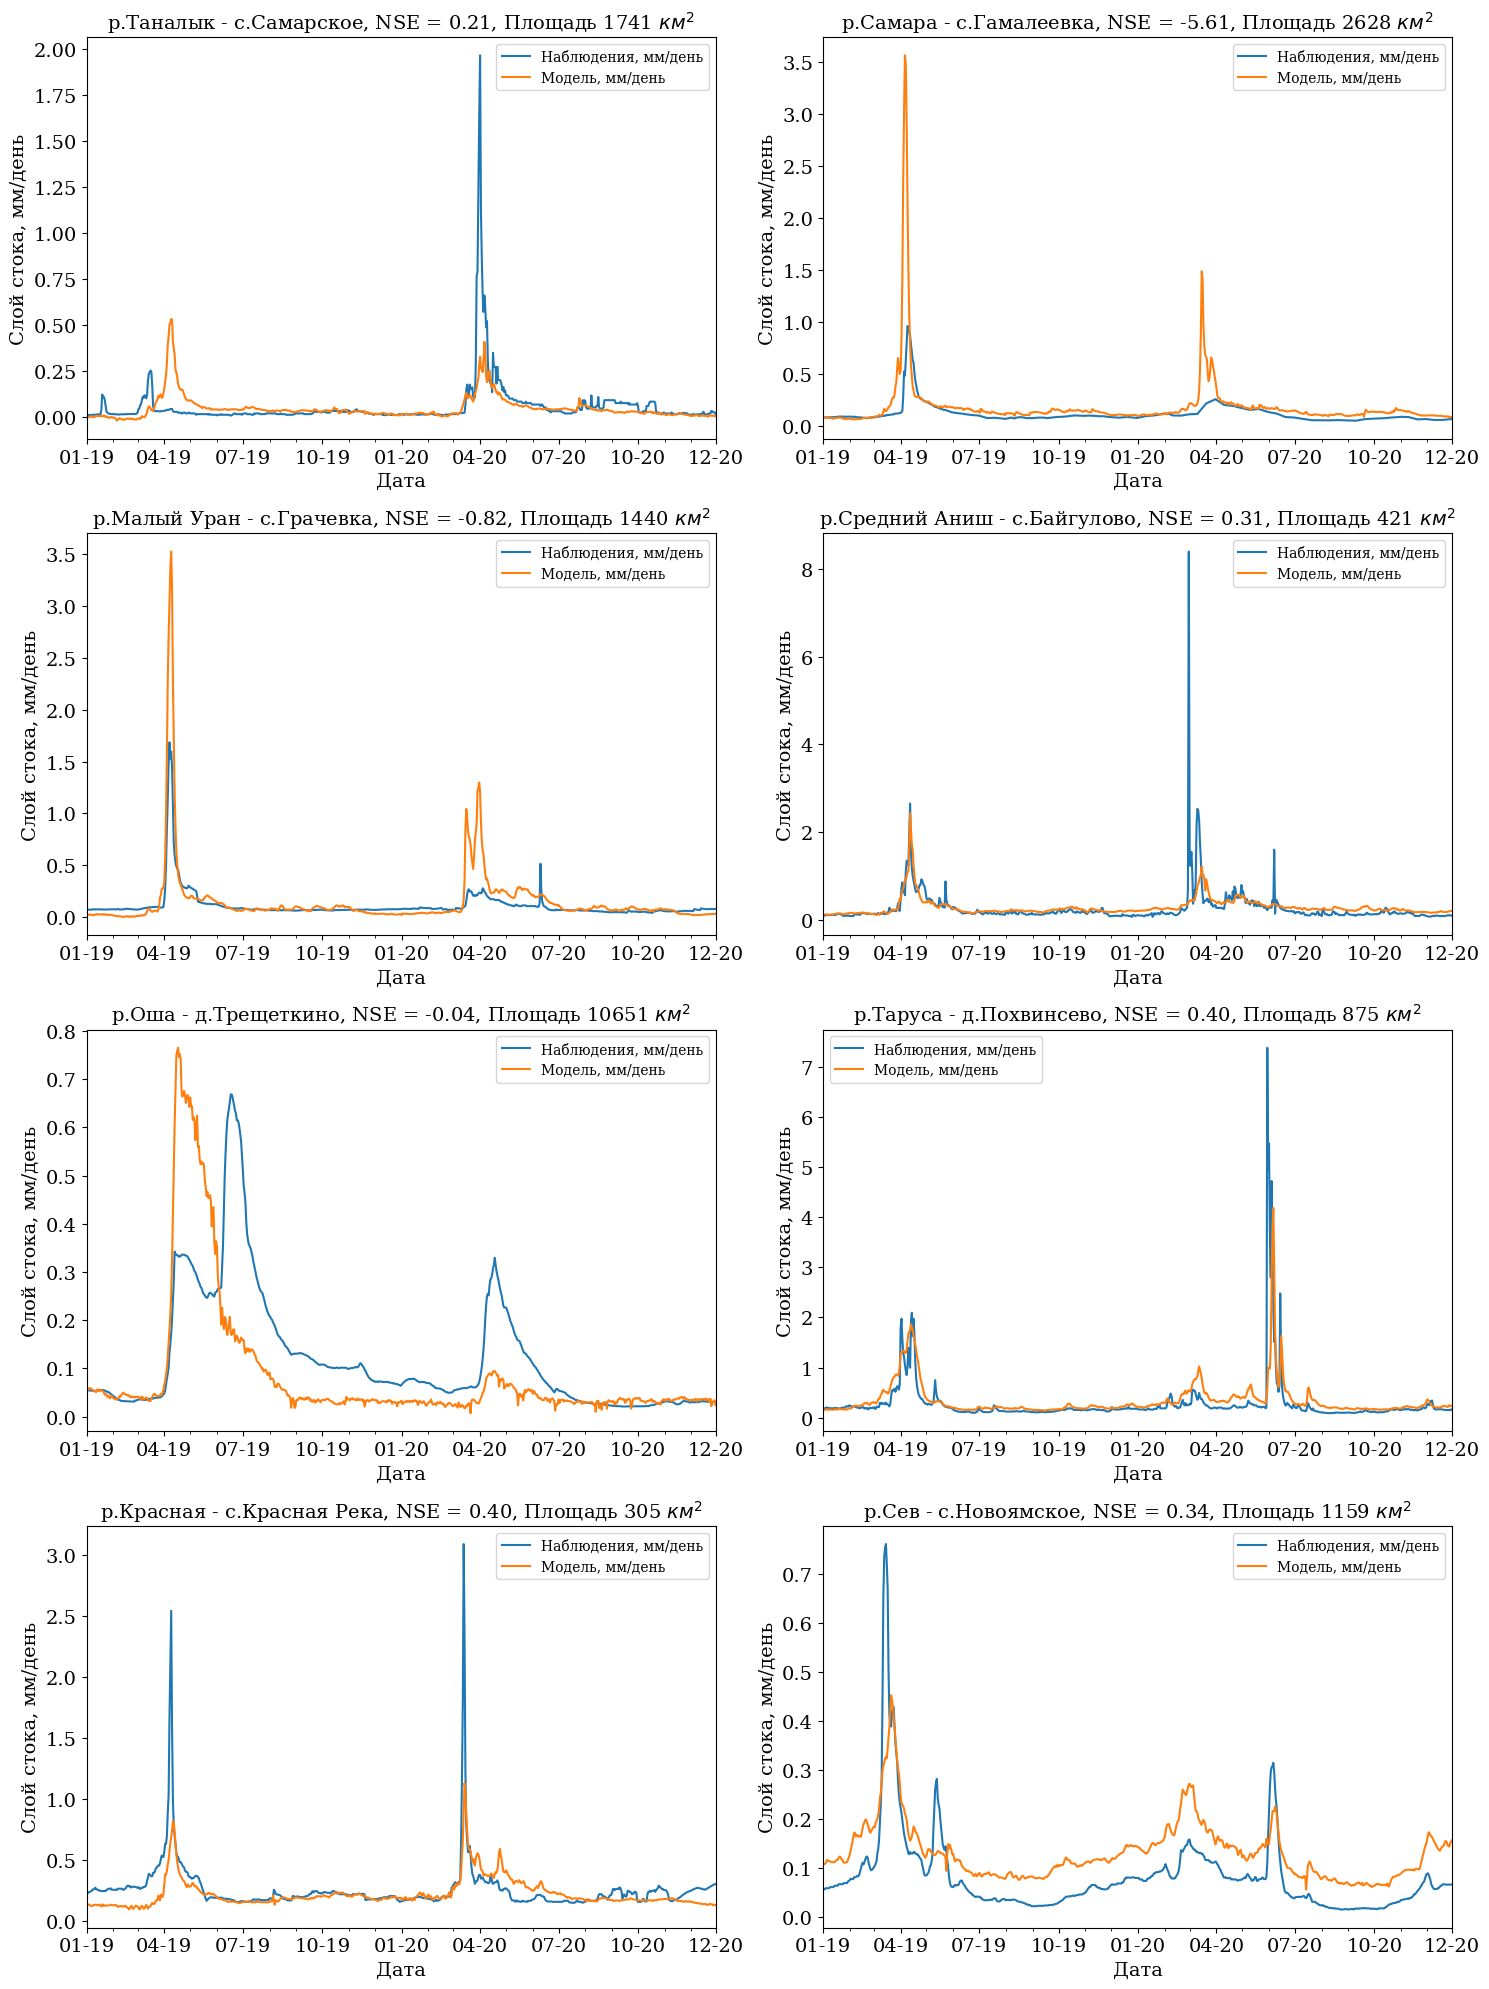

In [74]:
worst_4 = lstm_best_table[lstm_best_table["NSE"] < 0.5].sample(n=8)

mswep_pickle = Path(
    "/app/data/lstm_configs/model_runs/cudalstm_q_mm_day_mswep_no_autocorr_static_1103_191754/test/model_epoch024/test_results.p"
)
gpcp_pickle = Path(
    "/app/data/lstm_configs/model_runs/cudalstm_q_mm_day_gpcp_no_autocorr_static_1203_080402/test/model_epoch024/test_results.p"
)
era5l_pickle = Path(
    "/app/data/lstm_configs/model_runs/cudalstm_q_mm_day_era5l_no_autocorr_static_1003_133332/test/model_epoch026/test_results.p"
)
era5_pickle = Path(
    "/app/data/lstm_configs/model_runs/cudalstm_q_mm_day_era5_no_autocorr_static_1203_220232/test/model_epoch020/test_results.p"
)

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

date_form = DateFormatter("%m-%y")

for gauge_id, ax in zip(worst_4.index, np.ravel(axs)):
    if gauge_id in mswep_index:
        pickle_file = mswep_pickle
    elif gauge_id in gpcp_index:
        pickle_file = gpcp_pickle
    elif gauge_id in era5_index:
        pickle_file = era5_pickle
    else:
        pickle_file = era5l_pickle

    df_res = pd.read_pickle(pickle_file)[f"{gauge_id}"]["1D"]["xr"]

    draw_df = pd.DataFrame()
    obs, pred = (
        df_res["q_mm_day_obs"].to_numpy().squeeze()[:-1],
        df_res["q_mm_day_sim"].to_numpy().squeeze()[:-1],
    )

    draw_df.index = df_res.date[:-1]
    draw_df["Наблюдения, мм/день"] = obs
    draw_df["Модель, мм/день"] = pred

    draw_df.plot(
        ax=ax,
        title=f"{gauges_file.loc[gauge_id, 'name_ru']}, NSE = {worst_4.loc[gauge_id, 'NSE']:.2f}, Площадь {gauges_file.loc[gauge_id, 'new_area']:.0f} $км^2$",
        fontsize=14,
    )
    ax.title.set_size(14)
    ax.xaxis.set_major_formatter(date_form)
    ax.set_ylabel("Слой стока, мм/день", fontdict={"size": 14})
    ax.set_xlabel("Дата", fontdict={"size": 14})

plt.tight_layout()


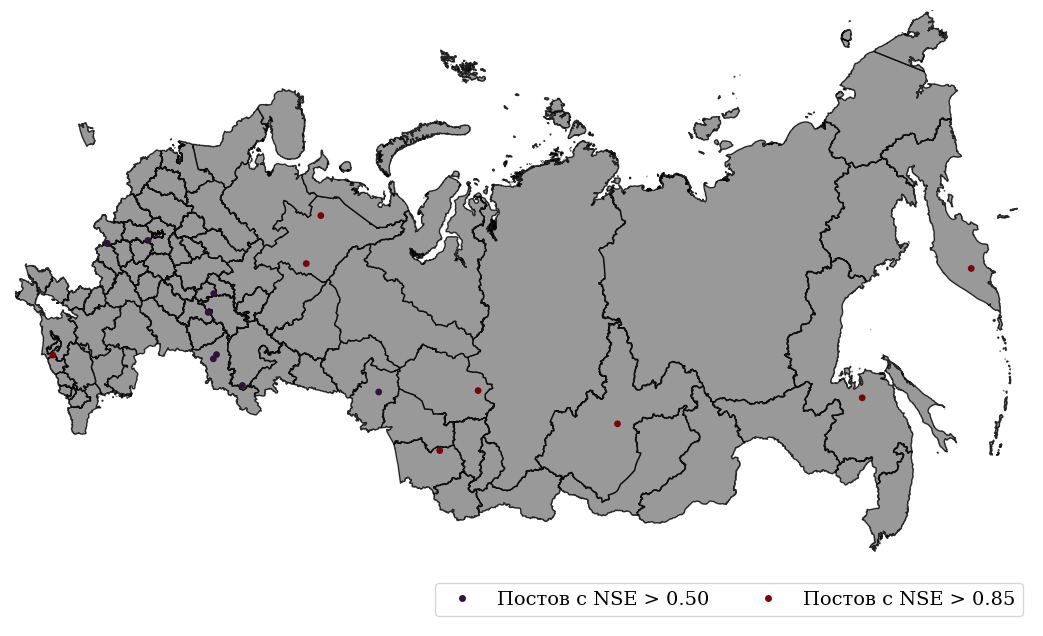

In [88]:
hydrograph_gauges = gauges_file.loc[common_index, ["geometry"]]

hydrograph_gauges.loc[best_4.index, "Гидрографы для"] = "Постов с NSE > 0.85"
hydrograph_gauges.loc[worst_4.index, "Гидрографы для"] = "Постов с NSE > 0.50"

hydrograph_gauges = hydrograph_gauges.dropna()

gauges_fig = russia_plots(
    gdf_to_plot=hydrograph_gauges,
    basemap_data=basemap_data,
    distinction_col="Гидрографы для",
    cmap_name="turbo",
    list_of_limits=list(range(1, 3)),
    figsize=(15, 8),
    just_points=True,
    legend_cols=4,
    with_histogram=False,
)


### Best model from each type for each gauge

In [ ]:
lstm_geom_nse["best NSE"] = lstm_geom_nse[
    ["NSE LSTM MSWEP", "NSE LSTM ERA5", "NSE LSTM ERA5-Land", "NSE LSTM GPCP"]
].max(axis=1)
mswep_index = lstm_geom_nse[lstm_geom_nse["best NSE"].isin(lstm_geom_nse["NSE LSTM MSWEP"])].index
era5_index = lstm_geom_nse[lstm_geom_nse["best NSE"].isin(lstm_geom_nse["NSE LSTM ERA5"])].index
era5_land_index = lstm_geom_nse[
    lstm_geom_nse["best NSE"].isin(lstm_geom_nse["NSE LSTM ERA5-Land"])
].index
gpcp_index = lstm_geom_nse[lstm_geom_nse["best NSE"].isin(lstm_geom_nse["NSE LSTM GPCP"])].index

for name, index in {
    "MSWEP": mswep_index,
    "ERA5": era5_index,
    "ERA5-Land": era5_land_index,
    "GPCP": gpcp_index,
}.items():
    lstm_geom_nse.loc[index, "Лучшая модель"] = name


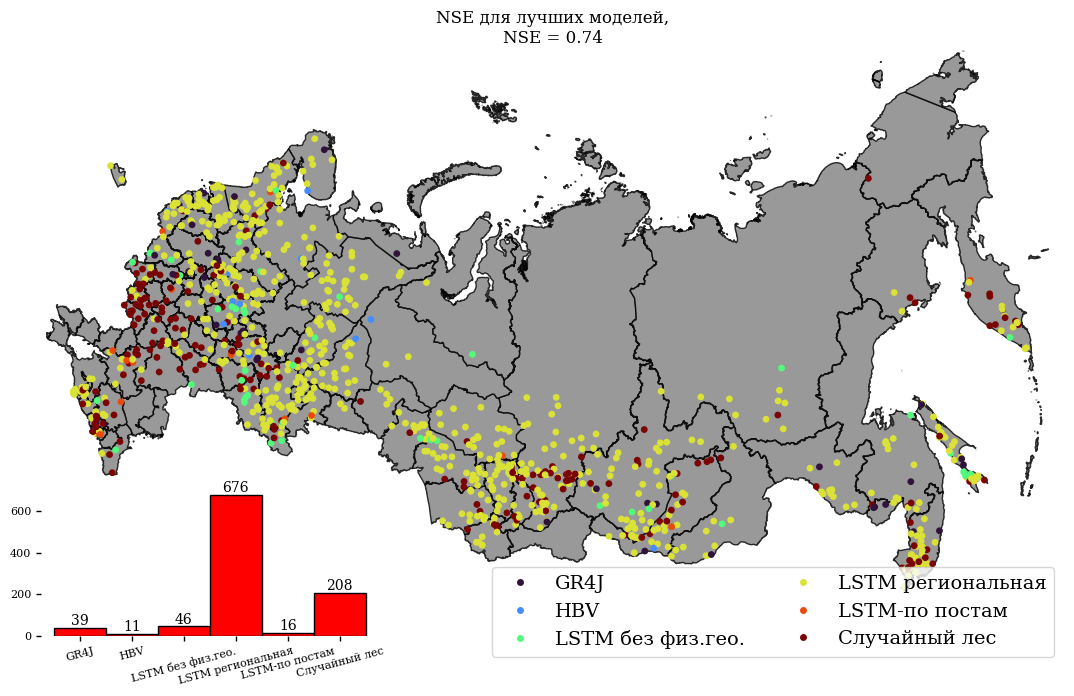

In [224]:
lstm_geom_nse = gauges_file.loc[common_index, ["geometry"]]


table_dict = {
    "HBV": hbv_table.loc[common_index, :],
    "GR4J": gr4j_table.loc[common_index, :],
    "Случайный лес": rfr_table.loc[common_index, :],
    "LSTM-по постам": lstm_single_table.loc[common_index, :],
    "LSTM без физ.гео.": lstm_vanila_table.loc[common_index, :],
    "LSTM региональная": lstm_best_table.loc[common_index, :],
}

best_nse_from_each_model = list()
for model, table in table_dict.items():
    model_table = table.rename(columns={"NSE": f"NSE {model}"})
    best_nse_from_each_model.append(model_table.loc[:, [f"NSE {model}"]])
best_nse_from_each_model = pd.concat(best_nse_from_each_model, axis=1)

lstm_geom_nse["best NSE"] = best_nse_from_each_model.max(axis=1)

hbv_index = lstm_geom_nse[lstm_geom_nse["best NSE"].isin(best_nse_from_each_model["NSE HBV"])].index
gr4j_index = lstm_geom_nse[lstm_geom_nse["best NSE"].isin(best_nse_from_each_model["NSE GR4J"])].index
rfr_index = lstm_geom_nse[
    lstm_geom_nse["best NSE"].isin(best_nse_from_each_model["NSE Случайный лес"])
].index
lstm_by_gauge_index = lstm_geom_nse[
    lstm_geom_nse["best NSE"].isin(best_nse_from_each_model["NSE LSTM-по постам"])
].index
lstm_no_phys_geo_index = lstm_geom_nse[
    lstm_geom_nse["best NSE"].isin(best_nse_from_each_model["NSE LSTM без физ.гео."])
].index
lstm_best_index = lstm_geom_nse[
    lstm_geom_nse["best NSE"].isin(best_nse_from_each_model["NSE LSTM региональная"])
].index
for name, index in {
    "HBV": hbv_index,
    "GR4J": gr4j_index,
    "Случайный лес": rfr_index,
    "LSTM-по постам": lstm_by_gauge_index,
    "LSTM без физ.гео.": lstm_no_phys_geo_index,
    "LSTM региональная": lstm_best_index,
}.items():
    lstm_geom_nse.loc[index, "Лучшая модель"] = name
gauges_fig = russia_plots(
    gdf_to_plot=lstm_geom_nse,
    basemap_data=basemap_data,
    distinction_col="Лучшая модель",
    cmap_name="turbo",
    # list_of_limits=list(range(0, 6)),
    title_text=f"NSE для лучших моделей,\nNSE = {lstm_geom_nse['best NSE'].median():.2f}",
    figsize=(15, 8),
    just_points=True,
    legend_cols=2,
    with_histogram=True,
)


In [222]:
lstm_geom_nse['best NSE'].median()

0.744689992049301

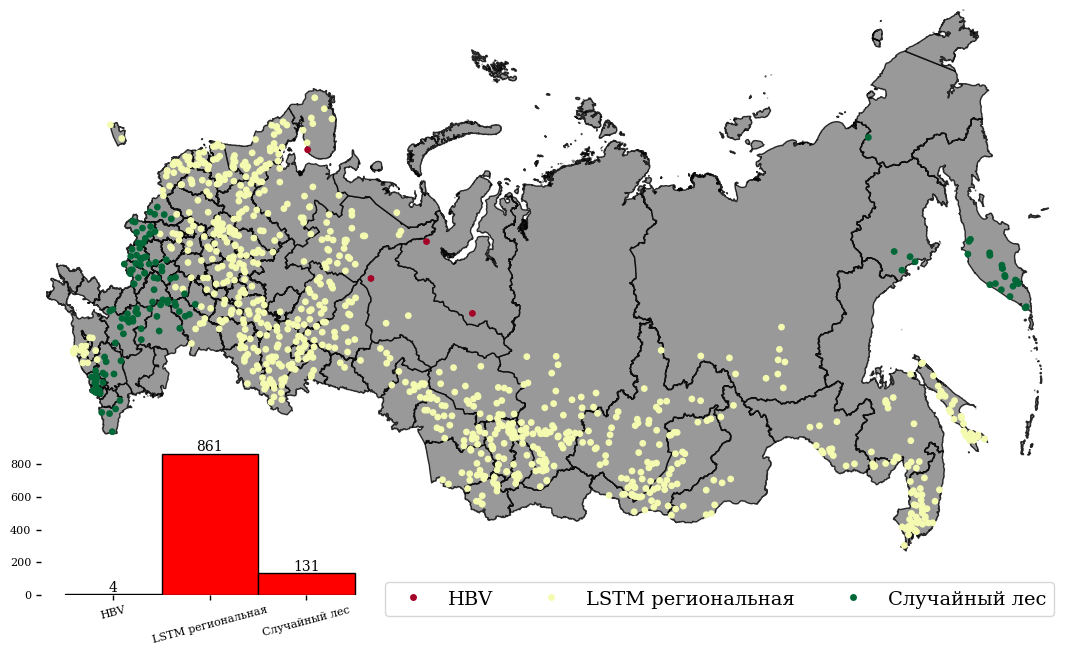

In [172]:
lstm_geom_nse_type = deepcopy(lstm_geom_nse)

model_dict = {
    "HBV": 1,
    "GR4J": 2,
    "Случайный лес": 3,
    # "LSTM MSWEP": lstm_regional_table.loc[common_index, :],
    "LSTM-по постам": 4,
    "LSTM без физ.гео.": 5,
    "LSTM региональная": 6,
    "Неоднозначно": 7,
    np.nan: np.nan,
}
cool_model = np.nan
for i, geom in enumerate(basin_districts["geometry"]):
    ugms_part = lstm_geom_nse_type.loc[
        [geom.intersects(gage_point) for gage_point in lstm_geom_nse_type["geometry"]], :
    ]
    ugms_name = basin_districts.loc[i, "name1"]
    try:
        example = ugms_part["Лучшая модель"].value_counts()

        for model, value in example.items():
            if value / example.sum() > 0.33:
                cool_model = model
                break
            else:
                cool_model = "Неоднозначно"

        # basin_districts.loc[i, ["Лучшая модель"]] = ugms_part["Лучшая модель"].value_counts().index[0]
        # basin_districts.loc[i, ["Лучшая модель"]] = model_dict[
        #     ugms_part["Лучшая модель"].value_counts().index[0]
        # ]
        basin_districts.loc[i, ["Лучшая модель"]] = model_dict[cool_model]
        lstm_geom_nse_type.loc[
            [geom.intersects(gage_point) for gage_point in lstm_geom_nse_type["geometry"]],
            ["Лучшая модель"],
        ] = cool_model
    except IndexError:
        basin_districts.loc[i, ["Лучшая модель"]] = np.nan
basin_districts.loc[[26, 27], ["Лучшая модель"]] = np.nan
# lstm_geom_nse_type["Лучшая модель"] = [model_dict[i] for i in lstm_geom_nse_type["Лучшая модель"]]

gauges_fig = russia_plots(
    gdf_to_plot=lstm_geom_nse_type,
    basemap_data=basemap_data,
    distinction_col="Лучшая модель",
    # cmap_name="turbo",
    list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True,
    legend_cols=3,
    with_histogram=True,
)
